(450176, 2)
Lỗi ở URL: http://ladiesfirst-privileges[.]com/656465/d5678h9.exe -- Invalid IPv6 URL
(208868, 2)
                                                      url  label
328491  https://www.yelp.com/biz/stone-mountain-clay-a...      0
60800              https://www.ivanhill5478.blogspot.com/      0
191230  https://www.facebook.com/people/Reggie-Walton/...      0
49392   https://www.freepages.genealogy.rootsweb.ances...      0
240956  https://www.manchester.edu/Athletics/basketbal...      0


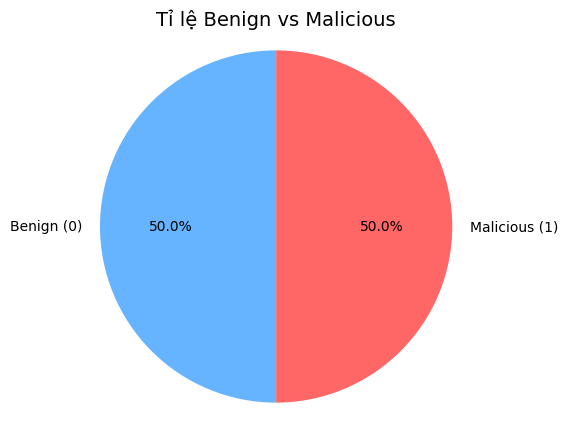

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# Load dữ liệu
df = pd.read_csv('/kaggle/input/malicious-and-benign-urls/urldata.csv')
df = df[['url', 'label']].dropna()
df['label'] = df['label'].map({'benign': 0, 'malicious': 1})
# print(df['url'].str.startswith('http').value_counts())
# Hàm kiểm tra URL hợp lệ

print(df.shape)
def is_valid_url(url):
    try:
        parsed = urlparse(url)
        return bool(parsed.scheme and parsed.netloc)
    except Exception as e:
        print(f"Lỗi ở URL: {url} -- {e}")
        return False

df = df[df['url'].apply(is_valid_url)].reset_index(drop=True)

from sklearn.utils import resample

# Tách hai lớp
df_benign = df[df['label'] == 0]
df_malicious = df[df['label'] == 1]

# Oversample df_malicious lên cùng số lượng với df_benign
df_benign_1 = resample(df_benign,
                      replace=False,  
                      n_samples=len(df_malicious),  
                      random_state=42)

# Gộp lại thành tập dữ liệu cân bằng
df_balanced = pd.concat([df_benign_1, df_malicious])
print(df_balanced.shape)
print(df_balanced.head())
label_counts = df_balanced['label'].value_counts().sort_index()

# Tạo nhãn tự động từ index
labels = [f'Benign (0)' if i == 0 else 'Malicious (1)' for i in label_counts.index]
colors = ['#66b3ff', '#ff6666']

# Vẽ pie chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Tỉ lệ Benign vs Malicious', fontsize=14)
plt.axis('equal')
plt.show()
# Chia train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced['url'].tolist(), df_balanced['label'].tolist(), test_size=0.2, random_state=42
)


In [2]:
from urllib.parse import urlparse, parse_qs

def preprocess_url(url):
    parsed = urlparse(url)
    parts = [
        parsed.scheme,
        parsed.netloc,
        parsed.path,
        parsed.params,
        parsed.query,
        parsed.fragment
    ]
    return ' '.join(filter(None, parts))

train_texts = [preprocess_url(url) for url in train_texts]
test_texts = [preprocess_url(url) for url in test_texts]

In [3]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

2025-08-09 02:34:07.345070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754706847.519207      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754706847.565960      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

from transformers import AddedToken

# 1) Token "chữ và số" an toàn (không dấu chấm) — dễ match với WordPiece
file_ext_plain = [
    "exe","dll","scr","com","bat","cmd","vbs","vbe","js","jse","ps1","psm1",
    "jar","apk","msi","msix","msixbundle","appx","dmg","pkg","run","sh",
    "zip","rar","7z","gz","bz2","xz","tar","tgz","cab","iso",
    "html","htm","shtml","php","asp","aspx","jsp","cgi",
    "doc","docx","xls","xlsx","ppt","pptx","pdf","rtf"
]

phishing_keywords = [
    "login","signin","verify","verification","update","reset","recovery",
    "password","pass","passwd","credential","account","secure","security",
    "confirm","support","helpdesk","admin","wp-admin","wp-login","oauth","sso",
    "download","install","free","gift","bonus","prize","win","giveaway",
    "invoice","payment","billing",
    "bank","paypal","appleid","microsoft","office365","sharepoint",
    "onedrive","drive","dropbox","telegram","whatsapp","crypto","wallet",
    "airdrop","metamask","seed","mnemonic","keygen","crack","serial"
]

query_params_plain = [
    "id","user","uid","token","key","session","sess","sid",
    "redirect","return","continue","next","dest","url","ref","r","u",
    "utm_source","utm_medium","utm_campaign",
    "file","filename","attachment","download","dl","exec","cmd"
]

# 2) Pattern hay bị obfuscate/encode
obfuscation_plain = [
    "hxxp","hxxps","xn--","0x","base64","aHR0cDov","aHR0cHM6"  # base64('http','https') mẫu hay gặp
]

protocols_plain = ["http","https","ftp","ftps","sftp","file","data","javascript"]

# 3) Các token có dấu / dấu chấm… cần giữ nguyên (không tách)
punct_tokens = [
    ".exe",".dll",".scr",".bat",".cmd",".vbs",".js",".ps1",".jar",".apk",".msi",".dmg",".pkg",
    ".zip",".rar",".7z",".gz",".bz2",".xz",".tar",".tgz",".cab",".iso",
    ".html",".htm",".shtml",".php",".asp",".aspx",".jsp",".cgi",
    "://","//","../","./","?","&","=","#","%","@",
    "%2e","%2f","%5c","%3a","%3f","%26","%3d","%23","%40","%00","%0d%0a",
    "data:","javascript:","ftp:","file:"
]

# Gom và loại trùng
plain_tokens = sorted(set(
    file_ext_plain + phishing_keywords + query_params_plain + obfuscation_plain + protocols_plain
))

added_punct_tokens = [AddedToken(t, lstrip=False, rstrip=False, normalized=False) for t in punct_tokens]

# Thêm vào tokenizer
n_plain = tokenizer.add_tokens(plain_tokens)
n_punct = tokenizer.add_tokens(added_punct_tokens)

print(f"Added plain tokens: {n_plain}, punct tokens: {n_punct}")

model.resize_token_embeddings(len(tokenizer))

train_encodings = tokenizer(train_texts, truncation=True, max_length=128)
test_encodings  = tokenizer(test_texts,  truncation=True, max_length=128)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added plain tokens: 140, punct tokens: 56


In [5]:
import torch

class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
        
train_dataset = URLDataset(train_encodings, train_labels)
test_dataset = URLDataset(test_encodings, test_labels)


In [6]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="/kaggle/working/bert_output",
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 2,
    warmup_steps=0,
    warmup_ratio=0.1,      
    weight_decay=0.01,
    logging_dir="/kaggle/working/logs",
    logging_steps=10,  
    save_total_limit=1,
    save_strategy="epoch",
    eval_strategy="epoch",   
    eval_steps=200,                
    logging_strategy="epoch", 
    fp16 = True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

def compute_metrics(pred):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score

    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = pred.predictions[:, 1]  # Xác suất class 1 (malicious)

    # Các chỉ số cơ bản
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    # ROC-AUC và PR-AUC
    roc_auc = roc_auc_score(labels, probs)
    pr_auc = average_precision_score(labels, probs)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
1,0.049800,0.017061,0.996218,0.995575,0.996903,0.996239,0.999623,0.999717
2,0.015000,0.014832,0.997271,0.998186,0.996379,0.997282,0.999643,0.999404
3,0.009900,0.014101,0.997582,0.998330,0.996855,0.997592,0.999750,0.999792
4,0.005500,0.021583,0.997654,0.998235,0.997094,0.997664,0.999386,0.999392
5,0.004000,0.021604,0.997702,0.998997,0.996427,0.997710,0.999441,0.999367
6,0.003000,0.019479,0.997582,0.998092,0.997094,0.997593,0.999151,0.998910
7,0.001800,0.024821,0.997582,0.998901,0.996284,0.997591,0.998763,0.998737
8,0.001500,0.024175,0.997367,0.999378,0.995379,0.997374,0.999679,0.999748
9,0.000700,0.023651,0.997798,0.998759,0.996855,0.997806,0.999515,0.999559
10,0.000300,0.024795,0.997750,0.998521,0.996998,0.997759,0.999457,0.999379


TrainOutput(global_step=104440, training_loss=0.009153846279500043, metrics={'train_runtime': 16617.7586, 'train_samples_per_second': 100.551, 'train_steps_per_second': 6.285, 'total_flos': 5.813197137674844e+16, 'train_loss': 0.009153846279500043, 'epoch': 10.0})

In [7]:
# Trong notebook cuối cùng, dùng TensorBoard
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs


<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20785
           1       1.00      1.00      1.00     20989

    accuracy                           1.00     41774
   macro avg       1.00      1.00      1.00     41774
weighted avg       1.00      1.00      1.00     41774



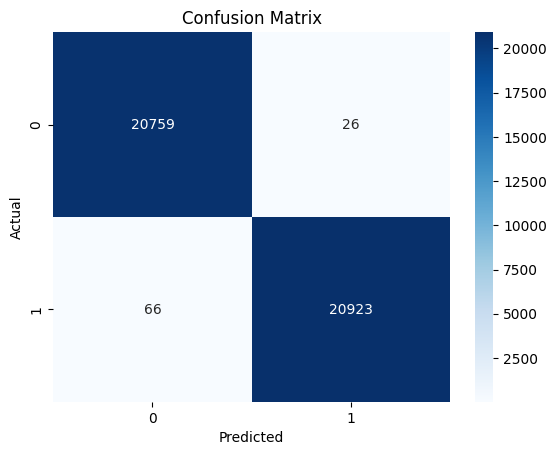

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_labels

# Báo cáo
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


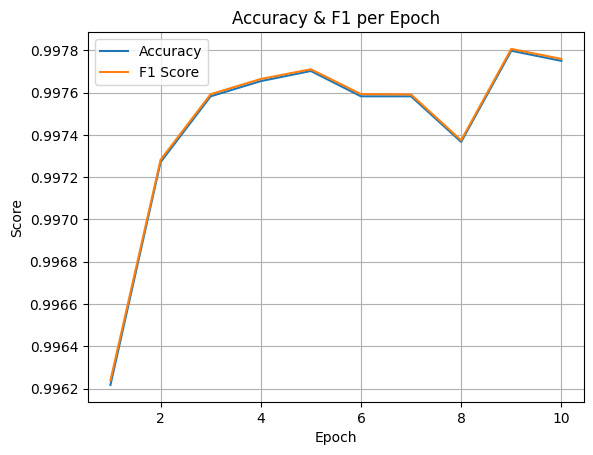

In [9]:
# Lấy logs từ trainer.state.log_history
logs = trainer.state.log_history

epochs = [log['epoch'] for log in logs if 'eval_loss' in log]
accuracy = [log['eval_accuracy'] for log in logs if 'eval_loss' in log]
f1 = [log['eval_f1'] for log in logs if 'eval_loss' in log]

plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, f1, label='F1 Score')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy & F1 per Epoch")
plt.legend()
plt.grid(True)
plt.show()


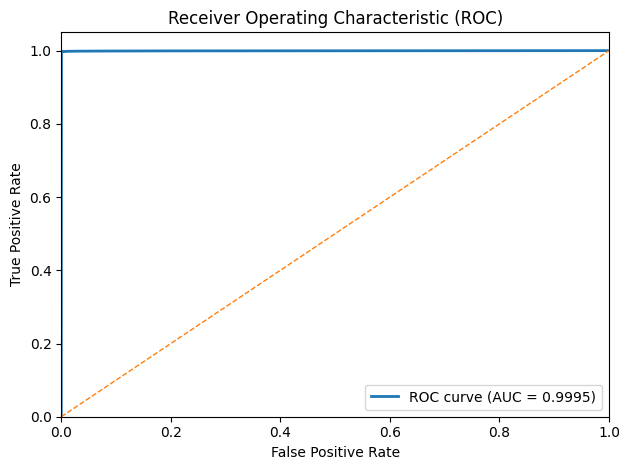

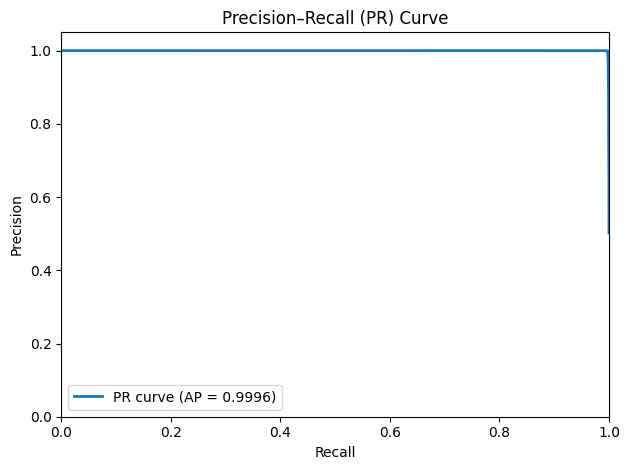

ROC-AUC: 0.999515 | PR-AUC (AP): 0.999559
Đã lưu: /kaggle/working/roc_curve.png và /kaggle/working/pr_curve.png


In [10]:
# ==== SAU KHI TRAIN XONG ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Lấy dự đoán trên test set
pred_output = trainer.predict(test_dataset)
y_true = pred_output.label_ids
# Lấy xác suất lớp 1 (malicious)
y_score = pred_output.predictions[:, 1]

# ----- ROC -----
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/kaggle/working/roc_curve.png", dpi=150)
plt.show()

# ----- Precision-Recall -----
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)

plt.figure()
plt.plot(recall, precision, lw=2, label=f"PR curve (AP = {pr_auc:.4f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (PR) Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("/kaggle/working/pr_curve.png", dpi=150)
plt.show()

print(f"ROC-AUC: {roc_auc:.6f} | PR-AUC (AP): {pr_auc:.6f}")
print("Đã lưu: /kaggle/working/roc_curve.png và /kaggle/working/pr_curve.png")


In [11]:

model.save_pretrained("/kaggle/working/bert_url_model")


In [12]:
# from transformers import BertTokenizer, BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained("saved_model")
# tokenizer = BertTokenizer.from_pretrained("saved_model")
# model.eval()  # Chuyển sang chế độ inference


In [13]:
# import torch

# def predict_url(url_text):
#     inputs = tokenizer(url_text, return_tensors="pt", padding=True, truncation=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     logits = outputs.logits
#     predicted_class = torch.argmax(logits, dim=1).item()
#     return predicted_class  # 0: bình thường, 1: độc hại


In [14]:
# url = "http://example.com/bad-url"
# result = predict_url(url)

# if result == 1:
#     print("🔴 Độc hại")
# else:
#     print("🟢 Bình thường")
